In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# from utils import *

pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_columns', 100)
matplotlib.rcParams.update({"font.size": 16, 'lines.linewidth': 2.5})

In [7]:
# 将 csv 读到 DataFrame
def get_df(file, header=None):
    df = pd.read_csv(file, header=None) # header=None可明确使用传入的数据为header
    # df.columns = DF_HEADER.get(key, df.columns)
    # 从header文件中拿header并设置
    df.columns = pd.read_csv("{}.header".format(file.split('.csv')[0])).columns if header is None else header
    return df

DATA_DIR = './data/'
dfj = get_df(DATA_DIR + 'pai_job_table.csv')
dft = get_df(DATA_DIR + 'pai_task_table.csv')
dfi = get_df(DATA_DIR + 'pai_instance_table.csv')
dfs = get_df(DATA_DIR + 'pai_sensor_table.csv')
dfg = get_df(DATA_DIR + 'pai_group_tag_table.csv')
dfp = get_df(DATA_DIR + 'pai_machine_spec.csv')
dfm = get_df(DATA_DIR + 'pai_machine_metric.csv')

In [8]:
def get_dfia(dfi):
    dfi_s = dfi[dfi.start_time > 0][['job_name','task_name','start_time']].groupby(['job_name','task_name']).min()  # start_time
    dfi_e = dfi[dfi.end_time > 0][['job_name','task_name','end_time']].groupby(['job_name','task_name']).max()  # end_time
    dfi_m = dfi[(dfi.start_time > 0) & (dfi.end_time > 0)][['job_name','task_name','end_time','start_time']]
    dfi_m['runtime'] = dfi_m.end_time-dfi_m.start_time
    dfi_m = dfi_m.groupby(['job_name','task_name']).mean()[['runtime']].reset_index() # runtime
    dfi_u = dfi[['job_name','task_name','status']].drop_duplicates().groupby(['job_name','task_name']).max() # status
    dfia = dfi_u
    for df in [dfi_s, dfi_e, dfi_m]:
        dfia = dfia.merge(df, on=['job_name','task_name'], how='left')
    return dfia

def get_dfa(dft, dfj, dfi, dfg):
    print('dft + dfj ...')
    dfa = dft.merge(dfj, on=['job_name'], suffixes = ['','_j'])
    dfa.loc[dfa.start_time==0, 'start_time'] = np.nan
    dfa.loc[dfa.start_time==0, 'end_time'] = np.nan
    dfa['runtime'] = dfa.end_time - dfa.start_time
    print('dft + dfj + dfi ...')
    dfia = get_dfia(dfi)
    dfa = dfa.merge(dfia, on=['job_name','task_name'], suffixes=['','_i'])
    dfa['duration_min'] = dfa.runtime_i / 60  # duration of instances
    dfa['wait_time'] = dfa.start_time_i - dfa.start_time # task wait time
    dfa['start_date']=dfa.start_time.apply(pd.Timestamp, unit='s', tz='Asia/Shanghai') # task start time
    # dfa = dfa[dfa.status=='Terminated']
    print('dft + dfj + dfi + dfg ...')
    dfa = dfa.merge(dfg[[x for x in dfg.columns if x != 'user']], on='inst_id', how='left')  # reserve NaN ones by how='left'
    dfa.loc[dfa.group.isnull(),'group'] = dfa.loc[dfa.group.isnull(), 'user']  # fill group==NaN ones with user
    return dfa

dfa_all = get_dfa(dft, dfj, dfi, dfg)       # dfa: dataframe of task
dfa = dfa_all.head(10000)

dft + dfj ...
dft + dfj + dfi ...
dft + dfj + dfi + dfg ...


In [9]:
dfa.head(10)

,job_name,task_name,inst_num,status,start_time,end_time,plan_cpu,plan_mem,plan_gpu,gpu_type,inst_id,user,status_j,start_time_j,end_time_j,runtime,status_i,start_time_i,end_time_i,runtime_i,duration_min,wait_time,start_date,gpu_type_spec,group,workload
0,c936346f45eccd34bf748541,tensorflow,1.0,Terminated,2693235.0,2695847.0,600.0,29.296875,50.0,MISC,990f1799a5093b62142b101c0227875b81c7f0329301df98af1148ec8724,58540f191766,Terminated,2693235.0,2695847.0,2612.0,Terminated,2693240.0,2695847.0,2607.0,43.450000,5.0,1970-02-01 12:07:15+08:00,NaN,31c5b7fa71e1224f9dff5c5a4d24b571,NaN
1,455c3dec270f4777ad67721c,tensorflow,1.0,Terminated,3399583.0,3399732.0,600.0,29.296875,100.0,MISC,d94b4b01a6dd6c1865972cd628abe206422143ef37e6d449d4b2e862e574,ebba56ec23b9,Terminated,3399583.0,3399732.0,149.0,Terminated,3399681.0,3399732.0,51.0,0.850000,98.0,1970-02-09 16:19:43+08:00,NaN,5a3163d07db392e47b6f0d063906592f,NaN
2,ba64aa2f0feff18428923e92,tensorflow,1.0,Terminated,2152271.0,2158213.0,600.0,29.296875,50.0,MISC,af71dfe31db0378561e1bea2c26605f67cb7611f0d38661b43881a1c6006,de69ddc1064e,Terminated,2152271.0,2158213.0,5942.0,Terminated,2152280.0,2158213.0,5933.0,98.883333,9.0,1970-01-26 05:51:11+08:00,NaN,f94dcf2c0efdf3fd36f75dbe1709c43f,NaN
3,704783be2a4b7f88b8d2e4ee,worker,100.0,Failed,2172980.0,NaN,600.0,9.765625,10.0,MISC,a63da076c1210109040acf759e2c1d00b8abc2d84305990a5941d0142690,cfcb2e0deb93,Failed,2172974.0,2173216.0,NaN,Interrupted,2172995.0,NaN,NaN,NaN,15.0,1970-01-26 11:36:20+08:00,NaN,e933ce21ede6be61f206b69b225f9a4a,NaN
4,704783be2a4b7f88b8d2e4ee,ps,10.0,Running,2172974.0,2173216.0,600.0,19.531250,NaN,NaN,a63da076c1210109040acf759e2c1d00b8abc2d84305990a5941d0142690,cfcb2e0deb93,Failed,2172974.0,2173216.0,242.0,Running,NaN,NaN,NaN,NaN,NaN,1970-01-26 11:36:14+08:00,NaN,e933ce21ede6be61f206b69b225f9a4a,NaN
5,bce3b9c55772f9d1e85fe796,PyTorchWorker,4.0,Failed,2374681.0,NaN,400.0,10.000000,100.0,V100,8dd676ab7fef90186d5813c5255ce4e89b50bdd9854225e7fa082289c88f,11b3ab54fc9f,Failed,2374681.0,NaN,NaN,Interrupted,2374699.0,2378674.0,NaN,NaN,18.0,1970-01-28 19:38:01+08:00,V100,a2e43ea2be689ce60787b3174f3ffbbf,NaN
6,d45e51734a9bd73fb94fa849,xComputeWorker,1.0,Terminated,2359994.0,2360345.0,1000.0,19.550781,50.0,T4,b41f0a87eba4a15f63ca1e0a881921036522a70760a9936281e4cf026eb0,c4cbaac9966d,Terminated,2359994.0,2360345.0,351.0,Terminated,2359997.0,2360345.0,348.0,5.800000,3.0,1970-01-28 15:33:14+08:00,NaN,7755b21bfabe33c2399770fd4f3be0f9,NaN
7,b609d0b21c1702836d822f03,tensorflow,1.0,Terminated,2362291.0,2362331.0,600.0,29.296875,25.0,MISC,cb177eaca0c98d42513f19dc593586f5768569b059e7a91d0b57605da35d,a7c4e1d6c98c,Terminated,2362291.0,2362331.0,40.0,Terminated,2362298.0,2362331.0,33.0,0.550000,7.0,1970-01-28 16:11:31+08:00,NaN,924cd0eabdc82669508175677273bcbc,NaN
8,547ad3599b438db832ed11e3,ps,5.0,Terminated,1258178.0,1259908.0,600.0,39.062500,NaN,NaN,6b2a4936ece386a95ce45581009bb9498f79a7c595d2413f0448517f2515,3a7b31330ae3,Terminated,1258178.0,1259908.0,1730.0,Terminated,1258181.0,1259908.0,1725.2,28.753333,3.0,1970-01-15 21:29:38+08:00,NaN,8e816282d753167dc900b997c717cdb5,NaN
9,547ad3599b438db832ed11e3,worker,20.0,Terminated,1258181.0,1259850.0,600.0,19.531250,50.0,MISC,6b2a4936ece386a95ce45581009bb9498f79a7c595d2413f0448517f2515,3a7b31330ae3,Terminated,1258178.0,1259908.0,1669.0,Terminated,1258225.0,1259850.0,1123.7,18.728333,44.0,1970-01-15 21:29:41+08:00,NaN,8e816282d753167dc900b997c717cdb5,NaN


In [10]:
dfa.drop(columns=['job_name', 'inst_id', 'user', 'group', 'gpu_type_spec', 'workload'], axis=1, inplace=True)

D:\Coding\Python39\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [11]:
dfa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype                        
---  ------        --------------  -----                        
 0   task_name     10000 non-null  object                       
 1   inst_num      10000 non-null  float64                      
 2   status        10000 non-null  object                       
 3   start_time    9979 non-null   float64                      
 4   end_time      7551 non-null   float64                      
 5   plan_cpu      9850 non-null   float64                      
 6   plan_mem      9850 non-null   float64                      
 7   plan_gpu      8047 non-null   float64                      
 8   gpu_type      8109 non-null   object                       
 9   status_j      10000 non-null  object                       
 10  start_time_j  9957 non-null   float64                      
 11  end_time_j    7784 non-null   float64     

In [12]:
# 删除含有缺失值的行
dfa.dropna(axis=0, subset=["start_time", "end_time", "plan_cpu", "plan_mem", "plan_gpu", "gpu_type", "start_time_j", "end_time_j", "runtime", "start_time_i", "end_time_i", "runtime_i", "duration_min", "wait_time", "start_date"], inplace=True)

D:\Coding\Python39\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [13]:
dfa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5998 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype                        
---  ------        --------------  -----                        
 0   task_name     5998 non-null   object                       
 1   inst_num      5998 non-null   float64                      
 2   status        5998 non-null   object                       
 3   start_time    5998 non-null   float64                      
 4   end_time      5998 non-null   float64                      
 5   plan_cpu      5998 non-null   float64                      
 6   plan_mem      5998 non-null   float64                      
 7   plan_gpu      5998 non-null   float64                      
 8   gpu_type      5998 non-null   object                       
 9   status_j      5998 non-null   object                       
 10  start_time_j  5998 non-null   float64                      
 11  end_time_j    5998 non-null   float64      

In [14]:
dfa.head(10)

,task_name,inst_num,status,start_time,end_time,plan_cpu,plan_mem,plan_gpu,gpu_type,status_j,start_time_j,end_time_j,runtime,status_i,start_time_i,end_time_i,runtime_i,duration_min,wait_time,start_date
0,tensorflow,1.0,Terminated,2693235.0,2695847.0,600.0,29.296875,50.0,MISC,Terminated,2693235.0,2695847.0,2612.0,Terminated,2693240.0,2695847.0,2607.000,43.450000,5.0,1970-02-01 12:07:15+08:00
1,tensorflow,1.0,Terminated,3399583.0,3399732.0,600.0,29.296875,100.0,MISC,Terminated,3399583.0,3399732.0,149.0,Terminated,3399681.0,3399732.0,51.000,0.850000,98.0,1970-02-09 16:19:43+08:00
2,tensorflow,1.0,Terminated,2152271.0,2158213.0,600.0,29.296875,50.0,MISC,Terminated,2152271.0,2158213.0,5942.0,Terminated,2152280.0,2158213.0,5933.000,98.883333,9.0,1970-01-26 05:51:11+08:00
6,xComputeWorker,1.0,Terminated,2359994.0,2360345.0,1000.0,19.550781,50.0,T4,Terminated,2359994.0,2360345.0,351.0,Terminated,2359997.0,2360345.0,348.000,5.800000,3.0,1970-01-28 15:33:14+08:00
7,tensorflow,1.0,Terminated,2362291.0,2362331.0,600.0,29.296875,25.0,MISC,Terminated,2362291.0,2362331.0,40.0,Terminated,2362298.0,2362331.0,33.000,0.550000,7.0,1970-01-28 16:11:31+08:00
9,worker,20.0,Terminated,1258181.0,1259850.0,600.0,19.531250,50.0,MISC,Terminated,1258178.0,1259908.0,1669.0,Terminated,1258225.0,1259850.0,1123.700,18.728333,44.0,1970-01-15 21:29:41+08:00
10,tensorflow,1.0,Terminated,1208483.0,1208543.0,600.0,29.296875,25.0,MISC,Terminated,1208483.0,1208543.0,60.0,Terminated,1208521.0,1208543.0,22.000,0.366667,38.0,1970-01-15 07:41:23+08:00
12,worker,80.0,Terminated,3028751.0,3093250.0,300.0,6.835938,25.0,P100,Terminated,3028709.0,3093306.0,64499.0,Terminated,3028753.0,3093250.0,64320.025,1072.000417,2.0,1970-02-05 09:19:11+08:00
14,worker,20.0,Terminated,2414380.0,2415569.0,600.0,29.296875,20.0,MISC,Terminated,2409576.0,2415625.0,1189.0,Terminated,2414421.0,2415569.0,988.700,16.478333,41.0,1970-01-29 06:39:40+08:00
15,PyTorchWorker,8.0,Terminated,2087083.0,2087221.0,1800.0,58.593750,100.0,MISC,Terminated,2087083.0,2087221.0,138.0,Terminated,2087091.0,2087221.0,127.875,2.131250,8.0,1970-01-25 11:44:43+08:00


In [15]:
# 查看某列不同的值
task_name_types = dfa['task_name'].unique()
print(task_name_types)

status_types = dfa['status'].unique()
print(status_types)

gpu_type_types = dfa['gpu_type'].unique()
print(gpu_type_types)

status_j_types = dfa['status_j'].unique()
print(status_j_types)

status_i_types = dfa['status_i'].unique()
print(status_i_types)


['tensorflow' 'xComputeWorker' 'worker' 'PyTorchWorker' 'ps' 'evaluator'
 'TVMTuneMain' 'OpenmpiWorker' 'OssToVolumeWorker' 'JupyterTask']
['Terminated' 'Failed']
['MISC' 'T4' 'P100' 'V100' 'V100M32']
['Terminated' 'Failed']
['Terminated' 'Failed']


In [16]:
# 转换数据类型 将非数值型转化为数值型
# from sklearn.preprocessing import LabelEncoder
# encoder = LabelEncoder().fit(dfa['status'])
# dfa['status'] = encoder.transform(dfa['status'])
# status_types = dfa['status'].unique()
# print(status_types)

# 为了清楚的知道映射关系 自己写
def trans_task_name_types(e):
    if e == 'tensorflow':
        return 0
    if e == 'xComputeWorker':
        return 1
    if e == 'worker':
        return 2
    if e == 'chief':
        return 3
    if e == 'PyTorchWorker':
        return 4
    if e == 'ps':
        return 5
    if e == 'evaluator':
        return 6
    if e == 'TVMTuneMain':
        return 7
    if e == 'OpenmpiWorker':
        return 8
    if e == 'OssToVolumeWorker':
        return 9
    if e == 'JupyterTask': 
        return 10
    if e == 'BladeMain':
        return 11

def trans_status_types(e):
    if e == 'Terminated':
        return 0
    if e == 'Failed':
        return 1
    if e == 'Running':
        return 2
    if e == 'Ready':
        return 4

def trans_gpu_type_types(e):
    if e == 'MISC':
        return 0
    if e == 'T4':
        return 1
    if e == 'P100':
        return 2
    if e == 'V100':
        return 3
    if e == 'V100M32':
        return 4

dfa['task_name'] = dfa['task_name'].apply(trans_task_name_types)
dfa['status'] = dfa['status'].apply(trans_status_types)
dfa['gpu_type'] = dfa['gpu_type'].apply(trans_gpu_type_types)
dfa['status_j'] = dfa['status_j'].apply(trans_status_types)
dfa['status_i'] = dfa['status_i'].apply(trans_status_types)


C:\Users\zonglin\AppData\Local\Temp/ipykernel_38388/2625684926.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfa['task_name'] = dfa['task_name'].apply(trans_task_name_types)
C:\Users\zonglin\AppData\Local\Temp/ipykernel_38388/2625684926.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfa['status'] = dfa['status'].apply(trans_status_types)
C:\Users\zonglin\AppData\Local\Temp/ipykernel_38388/2625684926.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

In [17]:
dfa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5998 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype                        
---  ------        --------------  -----                        
 0   task_name     5998 non-null   int64                        
 1   inst_num      5998 non-null   float64                      
 2   status        5998 non-null   int64                        
 3   start_time    5998 non-null   float64                      
 4   end_time      5998 non-null   float64                      
 5   plan_cpu      5998 non-null   float64                      
 6   plan_mem      5998 non-null   float64                      
 7   plan_gpu      5998 non-null   float64                      
 8   gpu_type      5998 non-null   int64                        
 9   status_j      5998 non-null   int64                        
 10  start_time_j  5998 non-null   float64                      
 11  end_time_j    5998 non-null   float64      

In [18]:
task_name_types = dfa['task_name'].unique()
print(task_name_types)

status_types = dfa['status'].unique()
print(status_types)

gpu_type_types = dfa['gpu_type'].unique()
print(gpu_type_types)

status_j_types = dfa['status_j'].unique()
print(status_j_types)

status_i_types = dfa['status_i'].unique()
print(status_i_types)


[ 0  1  2  4  5  6  7  8  9 10]
[0 1]
[0 1 2 3 4]
[0 1]
[0 1]


In [19]:
import time

# dtime = datetime.datetime.now()
# print(dtime)
# print(type(dtime))

# ans_t = time.mktime(dtime.timetuple())
# print(ans_t)
# print(type(ans_t))

# 将时间一列转化为时间戳
def trans_dates(e):
    return time.mktime(e.timetuple())

dfa['start_date'] = dfa['start_date'].apply(trans_dates)

dfa.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5998 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   task_name     5998 non-null   int64  
 1   inst_num      5998 non-null   float64
 2   status        5998 non-null   int64  
 3   start_time    5998 non-null   float64
 4   end_time      5998 non-null   float64
 5   plan_cpu      5998 non-null   float64
 6   plan_mem      5998 non-null   float64
 7   plan_gpu      5998 non-null   float64
 8   gpu_type      5998 non-null   int64  
 9   status_j      5998 non-null   int64  
 10  start_time_j  5998 non-null   float64
 11  end_time_j    5998 non-null   float64
 12  runtime       5998 non-null   float64
 13  status_i      5998 non-null   int64  
 14  start_time_i  5998 non-null   float64
 15  end_time_i    5998 non-null   float64
 16  runtime_i     5998 non-null   float64
 17  duration_min  5998 non-null   float64
 18  wait_time     5998 non-null 

C:\Users\zonglin\AppData\Local\Temp/ipykernel_38388/1039099579.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfa['start_date'] = dfa['start_date'].apply(trans_dates)


In [20]:
dfa.head(10)

,task_name,inst_num,status,start_time,end_time,plan_cpu,plan_mem,plan_gpu,gpu_type,status_j,start_time_j,end_time_j,runtime,status_i,start_time_i,end_time_i,runtime_i,duration_min,wait_time,start_date
0,0,1.0,0,2693235.0,2695847.0,600.0,29.296875,50.0,0,0,2693235.0,2695847.0,2612.0,0,2693240.0,2695847.0,2607.000,43.450000,5.0,2693235.0
1,0,1.0,0,3399583.0,3399732.0,600.0,29.296875,100.0,0,0,3399583.0,3399732.0,149.0,0,3399681.0,3399732.0,51.000,0.850000,98.0,3399583.0
2,0,1.0,0,2152271.0,2158213.0,600.0,29.296875,50.0,0,0,2152271.0,2158213.0,5942.0,0,2152280.0,2158213.0,5933.000,98.883333,9.0,2152271.0
6,1,1.0,0,2359994.0,2360345.0,1000.0,19.550781,50.0,1,0,2359994.0,2360345.0,351.0,0,2359997.0,2360345.0,348.000,5.800000,3.0,2359994.0
7,0,1.0,0,2362291.0,2362331.0,600.0,29.296875,25.0,0,0,2362291.0,2362331.0,40.0,0,2362298.0,2362331.0,33.000,0.550000,7.0,2362291.0
9,2,20.0,0,1258181.0,1259850.0,600.0,19.531250,50.0,0,0,1258178.0,1259908.0,1669.0,0,1258225.0,1259850.0,1123.700,18.728333,44.0,1258181.0
10,0,1.0,0,1208483.0,1208543.0,600.0,29.296875,25.0,0,0,1208483.0,1208543.0,60.0,0,1208521.0,1208543.0,22.000,0.366667,38.0,1208483.0
12,2,80.0,0,3028751.0,3093250.0,300.0,6.835938,25.0,2,0,3028709.0,3093306.0,64499.0,0,3028753.0,3093250.0,64320.025,1072.000417,2.0,3028751.0
14,2,20.0,0,2414380.0,2415569.0,600.0,29.296875,20.0,0,0,2409576.0,2415625.0,1189.0,0,2414421.0,2415569.0,988.700,16.478333,41.0,2414380.0
15,4,8.0,0,2087083.0,2087221.0,1800.0,58.593750,100.0,0,0,2087083.0,2087221.0,138.0,0,2087091.0,2087221.0,127.875,2.131250,8.0,2087083.0


In [21]:
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
dfa[['inst_num', 'plan_cpu', 'plan_mem', 'plan_gpu', 'runtime', 'runtime_i', 'duration_min', 'wait_time']] = scaler.fit_transform(dfa[['inst_num', 'plan_cpu', 'plan_mem', 'plan_gpu', 'runtime', 'runtime_i', 'duration_min', 'wait_time']])
dfa.head(10)



D:\Coding\Python39\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


,task_name,inst_num,status,start_time,end_time,plan_cpu,plan_mem,plan_gpu,gpu_type,status_j,start_time_j,end_time_j,runtime,status_i,start_time_i,end_time_i,runtime_i,duration_min,wait_time,start_date
0,0,0.000000,0,2693235.0,2695847.0,0.066148,0.096185,0.061327,0,0,2693235.0,2695847.0,0.006971,0,2693240.0,2695847.0,0.006980,0.006980,0.000018,2693235.0
1,0,0.000000,0,3399583.0,3399732.0,0.066148,0.096185,0.123905,0,0,3399583.0,3399732.0,0.000377,0,3399681.0,3399732.0,0.000136,0.000136,0.000428,3399583.0
2,0,0.000000,0,2152271.0,2158213.0,0.066148,0.096185,0.061327,0,0,2152271.0,2158213.0,0.015885,0,2152280.0,2158213.0,0.015886,0.015886,0.000035,2152271.0
6,1,0.000000,0,2359994.0,2360345.0,0.110617,0.063645,0.061327,1,0,2359994.0,2360345.0,0.000918,0,2359997.0,2360345.0,0.000932,0.000932,0.000009,2359994.0
7,0,0.000000,0,2362291.0,2362331.0,0.066148,0.096185,0.030038,0,0,2362291.0,2362331.0,0.000086,0,2362298.0,2362331.0,0.000088,0.000088,0.000026,2362291.0
9,2,0.076305,0,1258181.0,1259850.0,0.066148,0.063580,0.061327,0,0,1258178.0,1259908.0,0.004446,0,1258225.0,1259850.0,0.003009,0.003009,0.000190,1258181.0
10,0,0.000000,0,1208483.0,1208543.0,0.066148,0.096185,0.030038,0,0,1208483.0,1208543.0,0.000139,0,1208521.0,1208543.0,0.000059,0.000059,0.000163,1208483.0
12,2,0.317269,0,3028751.0,3093250.0,0.032796,0.021193,0.030038,2,0,3028709.0,3093306.0,0.172636,0,3028753.0,3093250.0,0.172223,0.172223,0.000004,3028751.0
14,2,0.076305,0,2414380.0,2415569.0,0.066148,0.096185,0.023780,0,0,2409576.0,2415625.0,0.003161,0,2414421.0,2415569.0,0.002647,0.002647,0.000177,2414380.0
15,4,0.028112,0,2087083.0,2087221.0,0.199555,0.194001,0.123905,0,0,2087083.0,2087221.0,0.000348,0,2087091.0,2087221.0,0.000342,0.000342,0.000031,2087083.0


In [30]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=20, algorithm='auto', contamination=0.1, n_jobs=-1, novelty=True)
clf.fit(dfa)

LocalOutlierFactor(contamination=0.1, n_jobs=-1, novelty=True)

In [31]:
clf.kneighbors(dfa)

(array([[    0.        ,  3257.24730409,  4368.93808608, ...,
          9282.20986619,  9422.63726353,  9993.44204966],
        [    0.        ,    47.69696007,   610.50143325, ...,
          5041.62890344,  5044.58759464,  5189.28723429],
        [    0.        ,  5817.81711641,  7114.41072753, ...,
         12357.61756974, 12545.2920253 , 12696.96148691],
        ...,
        [    0.        ,   381.02753755,   639.45132731, ...,
          8598.80084572,  8650.44796618,  8942.53331085],
        [    0.        ,  9553.66648776, 10307.13694561, ...,
         14428.51898152, 14723.95347777, 14873.51932126],
        [    0.        , 12105.95271189, 16238.65111586, ...,
         25498.98729392, 26377.05772127, 26725.6225936 ]]),
 array([[   0, 3150, 3327, ..., 4387, 5021, 2668],
        [   1, 1673,  667, ..., 2888, 2210, 1707],
        [   2, 3602,  244, ..., 5374, 3098, 1952],
        ...,
        [5995, 2947, 3106, ..., 2515, 5527, 1033],
        [5996, 4778,  641, ..., 4608, 3425, 5785

In [33]:
-clf.decision_function(dfa)

array([-0.34185317, -0.25699898, -0.34205332, ..., -0.32810202,
       -0.14760719, -0.15964379])

In [34]:
def localoutlierfactor(data, predict, k):
    from sklearn.neighbors import LocalOutlierFactor
    clf = LocalOutlierFactor(n_neighbors=k + 1, algorithm='auto', contamination=0.1, n_jobs=-1, novelty=True)
    clf.fit(data)
    # 记录 k 邻域距离
    predict['k distances'] = clf.kneighbors(predict)[0].max(axis=1)
    # 记录 LOF 离群因子，做相反数处理
    predict['local outlier factor'] = -clf._decision_function(predict.iloc[:, :-1])
    return predict

def plot_lof(result, method):
    import matplotlib.pyplot as plt
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
    plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
    plt.figure(figsize=(8, 4)).add_subplot(111)
    plt.scatter(result[result['local outlier factor'] > method].index,
                result[result['local outlier factor'] > method]['local outlier factor'], c='red', s=50,
                marker='.', alpha=None,
                label='离群点')
    plt.scatter(result[result['local outlier factor'] <= method].index,
                result[result['local outlier factor'] <= method]['local outlier factor'], c='black', s=50,
                marker='.', alpha=None, label='正常点')
    plt.hlines(method, -2, 2 + max(result.index), linestyles='--')
    plt.xlim(-2, 2 + max(result.index))
    plt.title('LOF局部离群点检测', fontsize=13)
    plt.ylabel('局部离群因子', fontsize=15)
    plt.legend()
    plt.show()

def lof(data, predict=None, k=5, method=1, plot=False):
    import pandas as pd
    # 判断是否传入测试数据，若没有传入则测试数据赋值为训练数据
    try:
        if predict == None:
            predict = data.copy()
    except Exception:
        pass
    predict = pd.DataFrame(predict)
    # 计算 LOF 离群因子
    predict = localoutlierfactor(data, predict, k)
    if plot == True:
        plot_lof(predict, method)
    # 根据阈值划分离群点与正常点
    outliers = predict[predict['local outlier factor'] > method].sort_values(by='local outlier factor')
    inliers = predict[predict['local outlier factor'] <= method].sort_values(by='local outlier factor')
    return outliers, inliers


In [60]:
run_i = np.array(dfa["plan_mem"][:]) 
run = np.array(dfa["plan_gpu"][:])
A = list(zip(run_i, run))  # 按照 runtime_instance runtime匹配

In [61]:
# 获取任务密度，取第5邻域，阈值为2（LOF大于2认为是离群值）
outliers1, inliers1 = lof(A, k=5, method = 10000)
outliers1

,0,1,k distances,local outlier factor
3613,0.014738,0.123905,0.000065,3.260515e+05
1798,0.014738,0.123905,0.000065,3.260515e+05
2600,0.014738,0.123905,0.000065,3.260515e+05
5348,0.031757,0.123905,0.000065,4.347354e+05
2501,0.031757,0.123905,0.000065,4.347354e+05
...,...,...,...,...
1631,0.194001,0.499374,0.097815,6.521030e+08
1222,0.194001,0.499374,0.097815,6.521030e+08
3497,0.194001,1.000000,0.376882,1.884412e+09
1023,0.194001,1.000000,0.376882,1.884412e+09


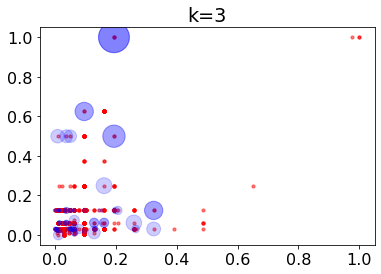

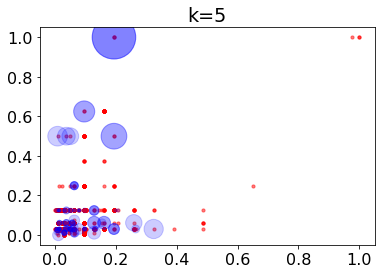

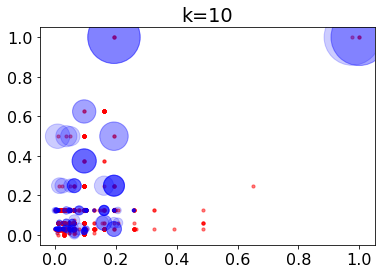

In [63]:
for k in [3,5,10]:
    plt.figure('k=%d'%k)
    outliers1, inliers1 = lof(A, k=k, method = 2)
    plt.scatter(np.array(A)[:,0],np.array(A)[:,1],s = 10,c='r',alpha = 0.5)
    # plt.scatter(outliers1[0],outliers1[1],s = 10+outliers1['local outlier factor']*100,c='r',alpha = 0.2)
    plt.scatter(outliers1[0],outliers1[1],s = 10+outliers1['local outlier factor']/1000000,c='b',alpha = 0.2)
    plt.title('k=%d' % k)